# Predicting Mortality of ICU Patients: the PhysioNet/Computing in Cardiology Challenge 2012

## BIOF509: Applied Machine Learning Final Project

by Kevin McPherson, Emma Macdonald, and Julio Gamarra
**Our names appear by the parts we did

<font color=red>**CAUTION**: you must use the command  `$pip install quilt`  ,  `$pip install missingno`  and  `$pip install fancyimpute` to run some of the commands in this notebook!</font>

## Step 1: Data Acquisition (Kevin McPherson)

The first step in our process was acquiring the data. The data was contained in individual folders for the training set ("Set A") and the testing set ("Set B"), each at different web URLs. The data was ugly, to begin with, as it was contained in .txt files with comma separated values (see https://physionet.org/challenge/2012/set-a/132539.txt for an example).

### A. Use wget to retrieve files

In [1]:
# Use wget to download train (A) and test (B) sets from PhysioNet website
!wget https://physionet.org/challenge/2012/set-a.zip
!wget https://physionet.org/challenge/2012/set-b.zip

--2019-05-20 22:08:06--  https://physionet.org/challenge/2012/set-a.zip
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘set-a.zip.38’

set-a.zip.38        100%[===================>]   7.57M  5.55MB/s    in 1.4s    

2019-05-20 22:08:07 (5.55 MB/s) - ‘set-a.zip.38’ saved [7938449/7938449]

--2019-05-20 22:08:07--  https://physionet.org/challenge/2012/set-b.zip
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7958979 (7.6M) [application/zip]
Saving to: ‘set-b.zip.38’

set-b.zip.38        100%[===================>]   7.59M  8.60MB/s    in 0.9s    

2019-05-20 22:08:09 (8.60 MB/s) - ‘set-b.zip.38’ saved [7958979/7958979]



In [2]:
# Download outcome sets from both train (A) and test (B)
!wget https://physionet.org/challenge/2012/Outcomes-a.txt
!wget https://physionet.org/challenge/2012/Outcomes-b.txt  

--2019-05-20 22:08:09--  https://physionet.org/challenge/2012/Outcomes-a.txt
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79219 (77K) [text/plain]
Saving to: ‘Outcomes-a.txt.38’

Outcomes-a.txt.38   100%[===================>]  77.36K  --.-KB/s    in 0.05s   

2019-05-20 22:08:09 (1.48 MB/s) - ‘Outcomes-a.txt.38’ saved [79219/79219]

--2019-05-20 22:08:09--  https://physionet.org/challenge/2012/Outcomes-b.txt
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79149 (77K) [text/plain]
Saving to: ‘Outcomes-b.txt.38’

Outcomes-b.txt.38   100%[===================>]  77.29K  --.-KB/s    in 0.06s   

2019-05-20 22:08:09 (1.26 MB/s) - ‘Outcomes-b.txt.38’ saved [79149/79149]



### B. Unzip train and test feature sets and store locally

In [3]:
# Unzip train and test sets
!unzip -u set-a.zip
!unzip -u set-b.zip

Archive:  set-a.zip
Archive:  set-b.zip


## Step 2: Data Preprocessing and Exploratory Data Analysis (Kevin McPherson/Emma MacDonald)

OK, this data is ugly! We need to do something about it. We know, maybe we can make a list of lists for each row (except for the header), and then make a time course for train and test data sets...

Addendum: After doing a bird's eye view of the project, we realized that this was the most time consuming step of them all. In fact, the challenge may have been predicated on how well each team could preprocess their data...one could only postulate about this... 

### A. First, a List of Lists! (Kevin McPherson)

In [4]:
import pandas as pd # Import pandas for data table manipulation
import numpy as np # Import numpy for array and numerical purposes
import os # Import os for local machine importing and set manipulation
import matplotlib.pyplot as plt # Import for visualization purposes

Now to make that list of lists we were talking about by reading the data and doing some comma splitting to get the lines read and in a data structure we can work with. 

In [5]:
train = 'set-a'
test = 'set-b'
train = [train]
test = [test]

txtfile_train = []
txtfile_test = []
for dataset in train:
    for f in os.listdir(dataset):
        with open(os.path.join(dataset,f), 'r') as fp:  # open the os path where our data is
            txt = fp.readlines()
            
        RecordID = txt[1].rstrip('\n').split(',')[-1] # Strip the \n, split the comma
        txt = [t.rstrip('\n').split(',') + [int(RecordID)] for t in txt]
        txtfile_train.extend(txt[1:])

for dataset in test:
    for f in os.listdir(dataset):
        with open(os.path.join(dataset,f), 'r') as fp: 
            txt = fp.readlines()
            
        RecordID = txt[1].rstrip('\n').split(',')[-1]
        txt = [t.rstrip('\n').split(',') + [int(RecordID)] for t in txt]
        txtfile_test.extend(txt[1:])

Train and test files are in a list of lists, with the RecordID pinned to each list. See below for the training set

In [6]:
txtfile_train

[['00:00', 'RecordID', '132592', 132592],
 ['00:00', 'Age', '35', 132592],
 ['00:00', 'Gender', '0', 132592],
 ['00:00', 'Height', '-1', 132592],
 ['00:00', 'ICUType', '3', 132592],
 ['00:00', 'Weight', '71.8', 132592],
 ['01:20', 'GCS', '15', 132592],
 ['01:20', 'HR', '112', 132592],
 ['01:20', 'NIDiasABP', '43', 132592],
 ['01:20', 'NIMAP', '68.67', 132592],
 ['01:20', 'NISysABP', '120', 132592],
 ['01:20', 'RespRate', '22', 132592],
 ['01:20', 'Temp', '36.6', 132592],
 ['01:20', 'Weight', '71.8', 132592],
 ['02:20', 'HR', '113', 132592],
 ['02:20', 'NIDiasABP', '53', 132592],
 ['02:20', 'NIMAP', '76.67', 132592],
 ['02:20', 'NISysABP', '124', 132592],
 ['02:20', 'RespRate', '21', 132592],
 ['02:20', 'Urine', '120', 132592],
 ['02:20', 'Weight', '71.8', 132592],
 ['02:36', 'BUN', '68', 132592],
 ['02:36', 'Creatinine', '2.3', 132592],
 ['02:36', 'Glucose', '603', 132592],
 ['02:36', 'HCO3', '11', 132592],
 ['02:36', 'HCT', '25.5', 132592],
 ['02:36', 'Mg', '2.8', 132592],
 ['02:36', 

Make a dataframe of train and test data with RecordID as a column to identify what each measurement goes to which patient

In [7]:
train = pd.DataFrame(txtfile_train, columns = ['Time', 'Parameter', 'Value', 'RecordID'])
test = pd.DataFrame(txtfile_test, columns = ['Time', 'Parameter', 'Value', 'RecordID'])

In [8]:
train

,Time,Parameter,Value,RecordID
0,00:00,RecordID,132592,132592
1,00:00,Age,35,132592
2,00:00,Gender,0,132592
3,00:00,Height,-1,132592
4,00:00,ICUType,3,132592
5,00:00,Weight,71.8,132592
6,01:20,GCS,15,132592
7,01:20,HR,112,132592
8,01:20,NIDiasABP,43,132592
9,01:20,NIMAP,68.67,132592


We can see by the table that there are a lot of features, something we'll get into more detail later, but first, just since we're curious, how many of these features are taken per patient?

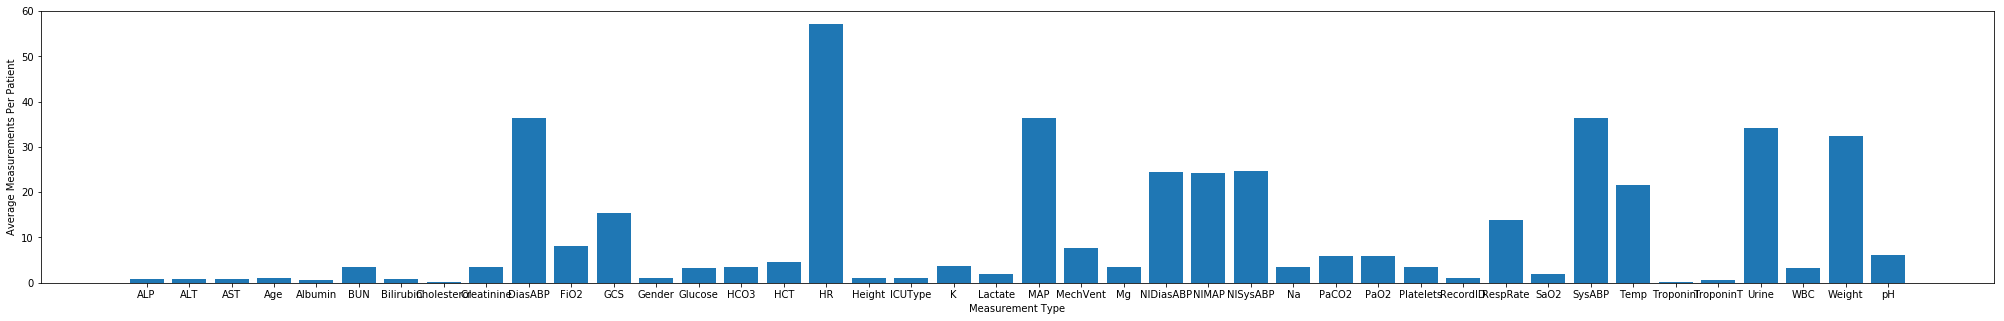

In [9]:
# Average number of measurements per patient bar graph
params_count = np.unique(train.Parameter,return_counts=True)
plt.figure(figsize=(35,5))
plt.bar(params_count[0],params_count[1]/4000)
plt.xlabel('Measurement Type')
plt.ylabel('Average Measurements Per Patient')
plt.show()

### B. Making a Static Variable Set (Kevin McPherson)

There are static variables in our dataset. As described from PhysioNet website, these data are:

> As noted, these six descriptors are collected at the time the patient is admitted to the ICU. Their associated time-stamps are set to 00:00 (thus they appear at the beginning of each patient's record): 
- RecordID (a unique integer for each ICU stay)
- Age (years)
- Gender (0: female, or 1: male)
- Height (cm)
- ICUType (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit, 3: Medical ICU, or 4: Surgical ICU) 
- Weight (kg)

Because such data exist, let's make static variable data frames with these data in them. **We chose to omit weight because it is actually a measurement taken more than once**

In [10]:
# Make a copy of test and train data, but of the indices of time 00:00
# Call this new df sTrain for s(tatic)Train and sTest for s(tatic)Test
# This will give us a huge df of all patient
sTrain = train.loc[train['Time'] == '00:00', :].copy()
sTest = test.loc[test['Time'] == '00:00', :].copy()

In [11]:
# Create static variable df with only static variables (i.e., without Weight)
static_var = ['RecordID','Age', 'Gender', 'Height', 'ICUType']
sTrain = sTrain.loc[train['Parameter'].isin(static_var)]
sTest = sTest.loc[test['Parameter'].isin(static_var)]
sTrain.head()

,Time,Parameter,Value,RecordID
0,00:00,RecordID,132592,132592
1,00:00,Age,35,132592
2,00:00,Gender,0,132592
3,00:00,Height,-1,132592
4,00:00,ICUType,3,132592


Now that we have each static variable dataframe, we can group them by RecordID and set them aside until we have to re-merge them with the feature dataframe. 

In [12]:
# Group all parameters by RecordID and Parameter (i.e, tests taken on patients)
# Last column will be taken as the value to avoid any duplicates..
sTrain = sTrain.groupby(['RecordID','Parameter'])[['Value']].last()
sTest = sTest.groupby(['RecordID','Parameter'])[['Value']].last()
sTrain.reset_index(inplace=True)
sTest.reset_index(inplace=True)
sTrain.head()

,RecordID,Parameter,Value
0,132539,Age,54
1,132539,Gender,0
2,132539,Height,-1
3,132539,ICUType,4
4,132539,RecordID,132539


### C. Taking the Static Variables out of the Feature Set (Kevin McPherson)

In [13]:
# Take the index of the static variable data sets
trainDrop = sTrain.index
testDrop = sTest.index

# Drop those indices from the train and test set
train = train.loc[~train.index.isin(trainDrop),:]
# train.head()
test = test.loc[~test.index.isin(testDrop),:]
test.head()

,Time,Parameter,Value,RecordID
20000,32:04,Weight,60,145242
20001,32:19,HR,82,145242
20002,32:19,NIDiasABP,55,145242
20003,32:19,NIMAP,74,145242
20004,32:19,NISysABP,112,145242


### D. Cleaning up the Static and Feature frames for some feature selection fun (Kevin McPherson)

In [14]:
# Put time in integer of hours for convenience...
train['time'] = train['Time'].map(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

# Make all parameter values numeric in all sets
train['Value'] = pd.to_numeric(train['Value'])
test['Value'] = pd.to_numeric(test['Value'])
sTrain['Value'] = pd.to_numeric(sTrain['Value'])
sTest['Value'] = pd.to_numeric(sTest['Value'])


/Users/kevinmcpherson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kevinmcpherson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
# Pivot static tables to be only RecordID sorted
sTrain = sTrain.pivot(index='RecordID', columns='Parameter', values='Value')
sTest = sTest.pivot(index='RecordID', columns='Parameter', values='Value')

In [16]:
sTrain.head() 

Parameter,Age,Gender,Height,ICUType,RecordID
RecordID,,,,,
132539,54.0,0.0,-1.0,4.0,132539.0
132540,76.0,1.0,175.3,2.0,132540.0
132541,44.0,0.0,-1.0,3.0,132541.0
132543,68.0,1.0,180.3,3.0,132543.0
132545,88.0,0.0,-1.0,3.0,132545.0


In [17]:
train.head()

,Time,Parameter,Value,RecordID,time
20000,39:01,pH,7.45,132960,2341
20001,39:01,PaCO2,28.00,132960,2341
20002,39:01,PaO2,74.00,132960,2341
20003,39:30,DiasABP,59.00,132960,2370
20004,39:30,HR,101.00,132960,2370


In [18]:
# Group train and test sets by RecordID for some heatmapping later on...
# The means were taken to safeguard against duplicates
train = train.groupby(['RecordID','Parameter'])[['Value']].mean()
test = test.groupby(['RecordID','Parameter'])[['Value']].mean()
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [19]:
# Pivot to final set...
train = train.pivot(index='RecordID',columns='Parameter',values='Value')
test = test.pivot(index='RecordID',columns='Parameter',values='Value')

In [20]:
train.head()

Parameter,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,...,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,NaN,NaN,NaN,54.0,NaN,10.500000,NaN,NaN,0.750000,NaN,...,17.428571,NaN,NaN,37.357143,NaN,NaN,171.052632,10.300000,-1.000000,NaN
132540,NaN,NaN,NaN,76.0,NaN,18.333333,NaN,NaN,1.100000,58.897059,...,NaN,96.833333,113.411765,36.939130,NaN,NaN,151.560976,11.266667,80.670588,7.395000
132541,116.0,83.0,199.5,44.0,2.5,4.666667,2.9,NaN,0.333333,67.125000,...,NaN,95.000000,125.687500,37.800000,NaN,NaN,124.951220,4.700000,56.700000,7.495000
132543,105.0,12.0,15.0,68.0,4.4,17.666667,0.2,NaN,0.766667,NaN,...,15.457627,NaN,NaN,36.223077,NaN,NaN,545.833333,9.400000,84.600000,NaN
132547,101.0,52.5,104.5,64.0,NaN,16.750000,0.4,212.0,0.975000,73.622222,...,NaN,97.000000,115.688889,37.577778,1.3,NaN,136.333333,16.100000,114.000000,7.405714


### E. Missing data, nullity, and decisions on feature engineering (Kevin McPherson)

Now that we are getting into the features of our data, it's important to explain them. There are many features that are taken at different timepoints for each individual patients. Not all measurement features are taken for each patient, and they are not done in a uniform fashion, so it is important to know them all. According to PhysioNet, they are as follows: 

> These 37 variables may be observed once, more than once, or not at all in some cases:

- Albumin (g/dL)
- ALP [Alkaline phosphatase (IU/L)]
- ALT [Alanine transaminase (IU/L)]
- AST [Aspartate transaminase (IU/L)]
- Bilirubin (mg/dL)
- BUN [Blood urea nitrogen (mg/dL)]
- Cholesterol (mg/dL)
- Creatinine [Serum creatinine (mg/dL)]
- DiasABP [Invasive diastolic arterial blood pressure (mmHg)]
- FiO2 [Fractional inspired O2 (0-1)]
- GCS [Glasgow Coma Score (3-15)]
- Glucose [Serum glucose (mg/dL)]
- HCO3 [Serum bicarbonate (mmol/L)]
- HCT [Hematocrit (%)]
- HR [Heart rate (bpm)]
- K [Serum potassium (mEq/L)]
- Lactate (mmol/L)
- Mg [Serum magnesium (mmol/L)]
- MAP [Invasive mean arterial blood pressure (mmHg)]
- MechVent [Mechanical ventilation respiration (0:false, or 1:true)]
- Na [Serum sodium (mEq/L)]
- NIDiasABP [Non-invasive diastolic arterial blood pressure (mmHg)]
- NIMAP [Non-invasive mean arterial blood pressure (mmHg)]
- NISysABP [Non-invasive systolic arterial blood pressure (mmHg)]
- PaCO2 [partial pressure of arterial CO2 (mmHg)]
- PaO2 [Partial pressure of arterial O2 (mmHg)]
- pH [Arterial pH (0-14)]
- Platelets (cells/nL)
- RespRate [Respiration rate (bpm)]
- SaO2 [O2 saturation in hemoglobin (%)]
- SysABP [Invasive systolic arterial blood pressure (mmHg)]
- Temp [Temperature (°C)]
- TropI [Troponin-I (μg/L)]
- TropT [Troponin-T (μg/L)]
- Urine [Urine output (mL)]
- WBC [White blood cell count (cells/nL)]
- Weight (kg)*

In [21]:
import matplotlib # Import for visualization wrangling and formatting
import missingno as msno # Import for missing data visualization
import matplotlib.pyplot as plt # # Import for vizualization
%matplotlib inline 

First of all, our notebook up to this point has been rather bland, don't you think? Let's look at some vizualizations of which dataframes in our feature sets have missing data, and to what degree.

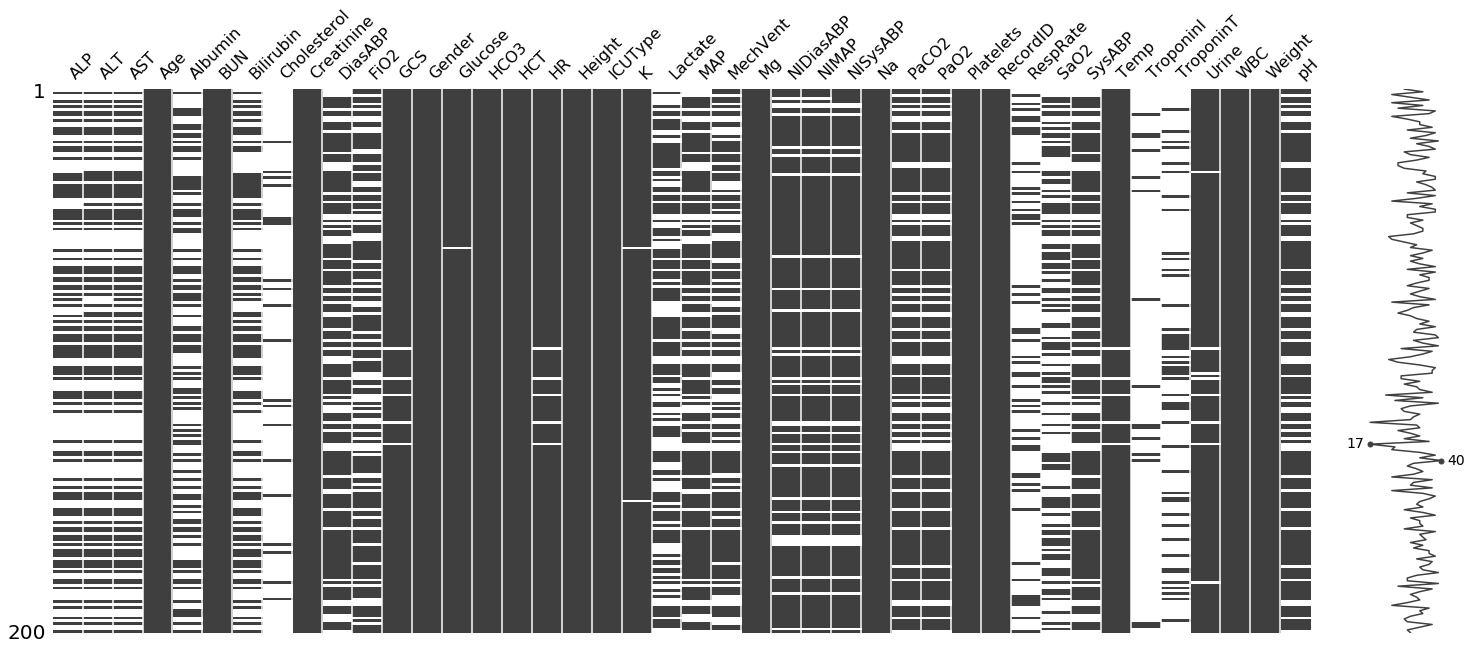

In [22]:
msno.matrix(train.sample(200))

We can also look at this as the amount of data that is complete, in a bar chart form, where the y-axes on either side are the raw amount of datapoints in the set (right hand y-axis) and the log value of their completeness (left hand y-axis). 

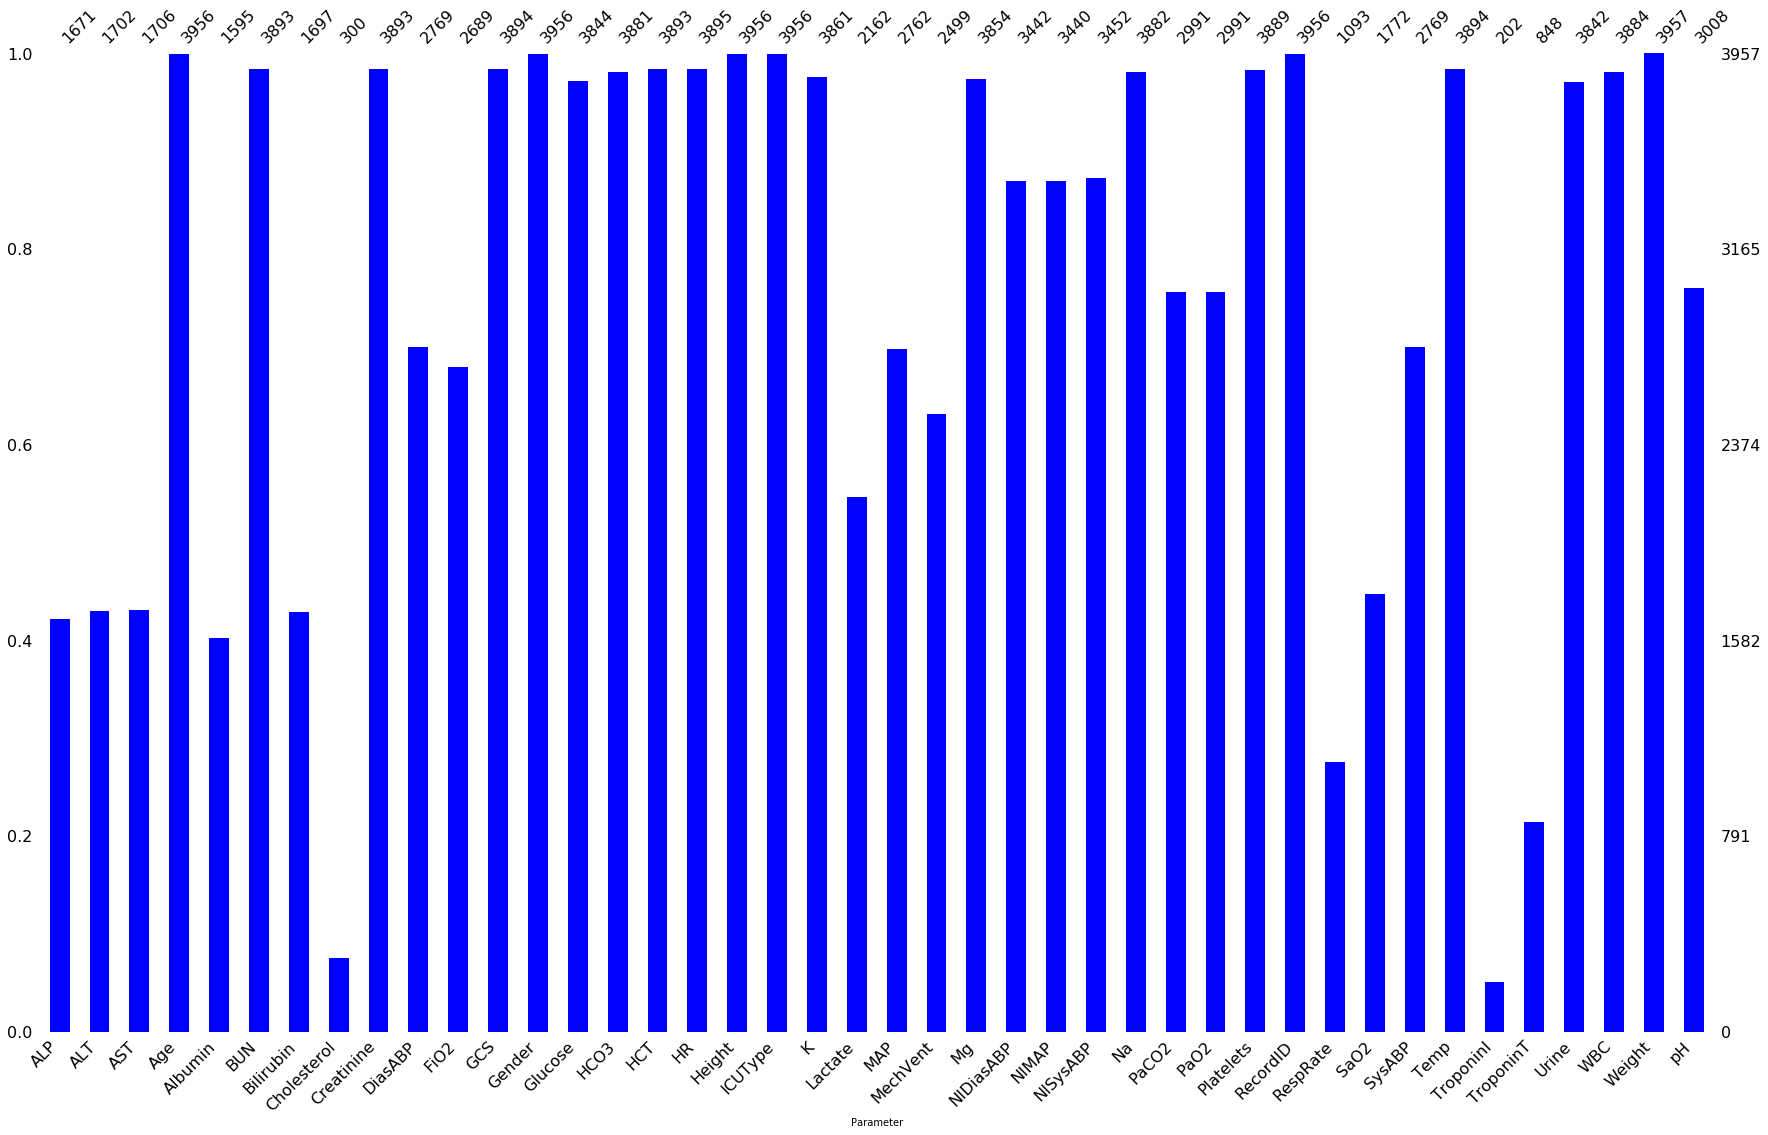

In [23]:
msno.bar(train, color="blue", figsize=(30,18))

We can also heatmap the data. As described by [Wale Akinfaderin](https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87), the heatmap can be understood this way: "...This map describes the degree of nullity relationship between the different features. The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1). Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed. Also, a perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values while a perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing." 

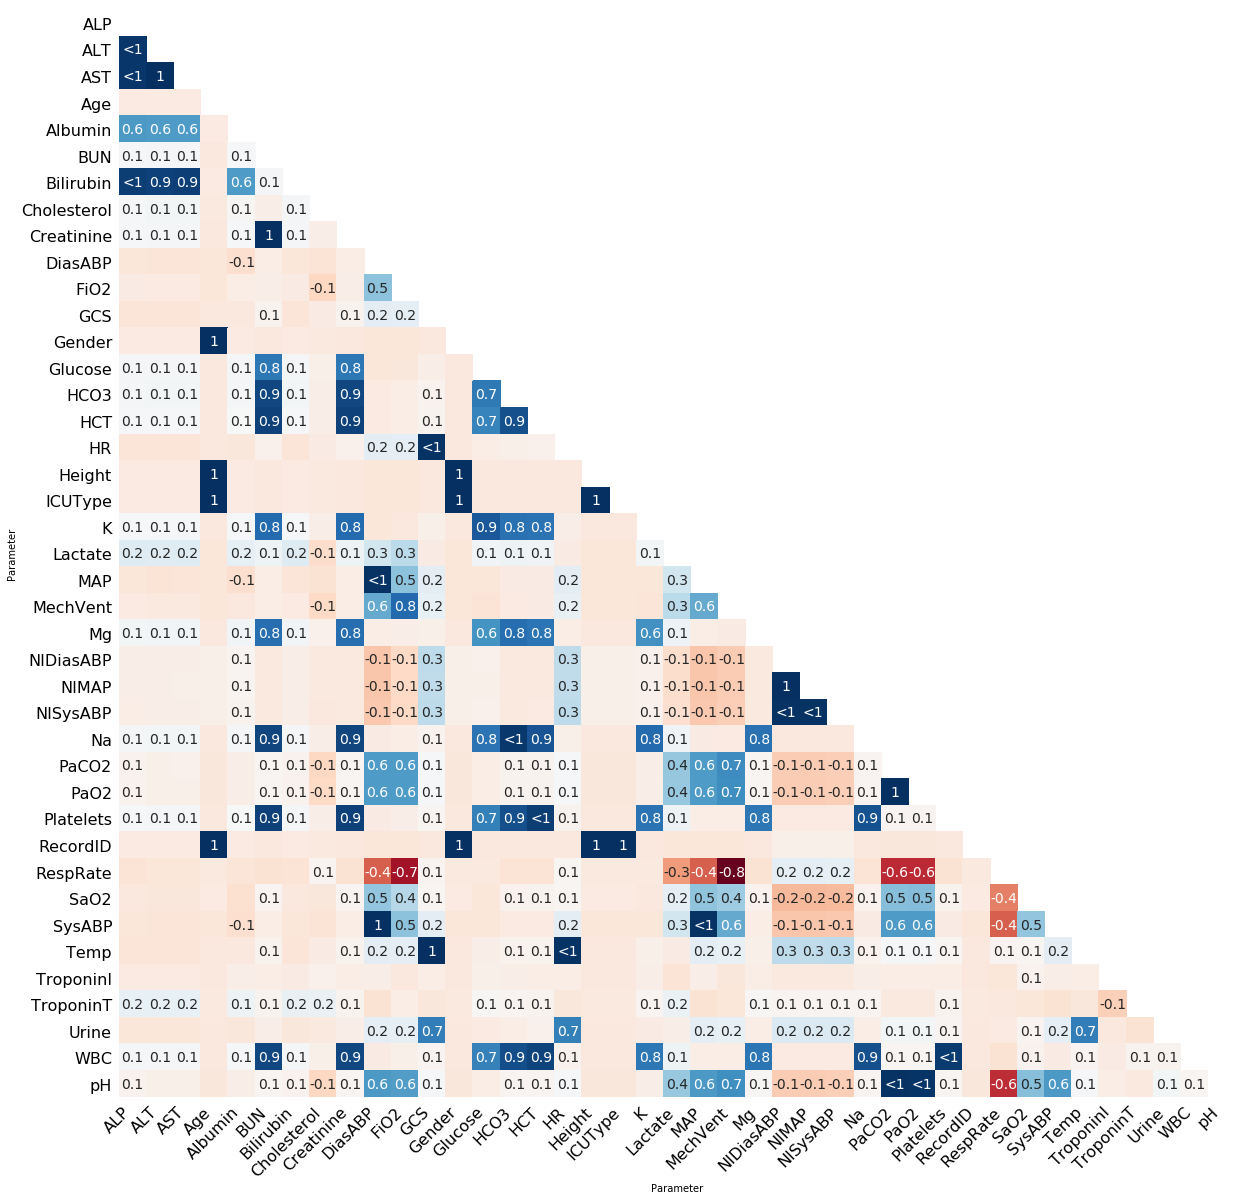

In [24]:
msno.heatmap(train, figsize=(20,20))

We can conclude that some features (RecordID, ICUType pair and Temp, GCS for example) go together. This might be useful in deciding what we can and cannot eliminate from our data.

In [25]:
import seaborn as sns # Import for heatmap use in correlation of features

If we heatmap our data using Seaborn, we can tell that we don't want to use all the features in our data set. There are over 42 of them anyway, when we take into account the static and non-static types! 

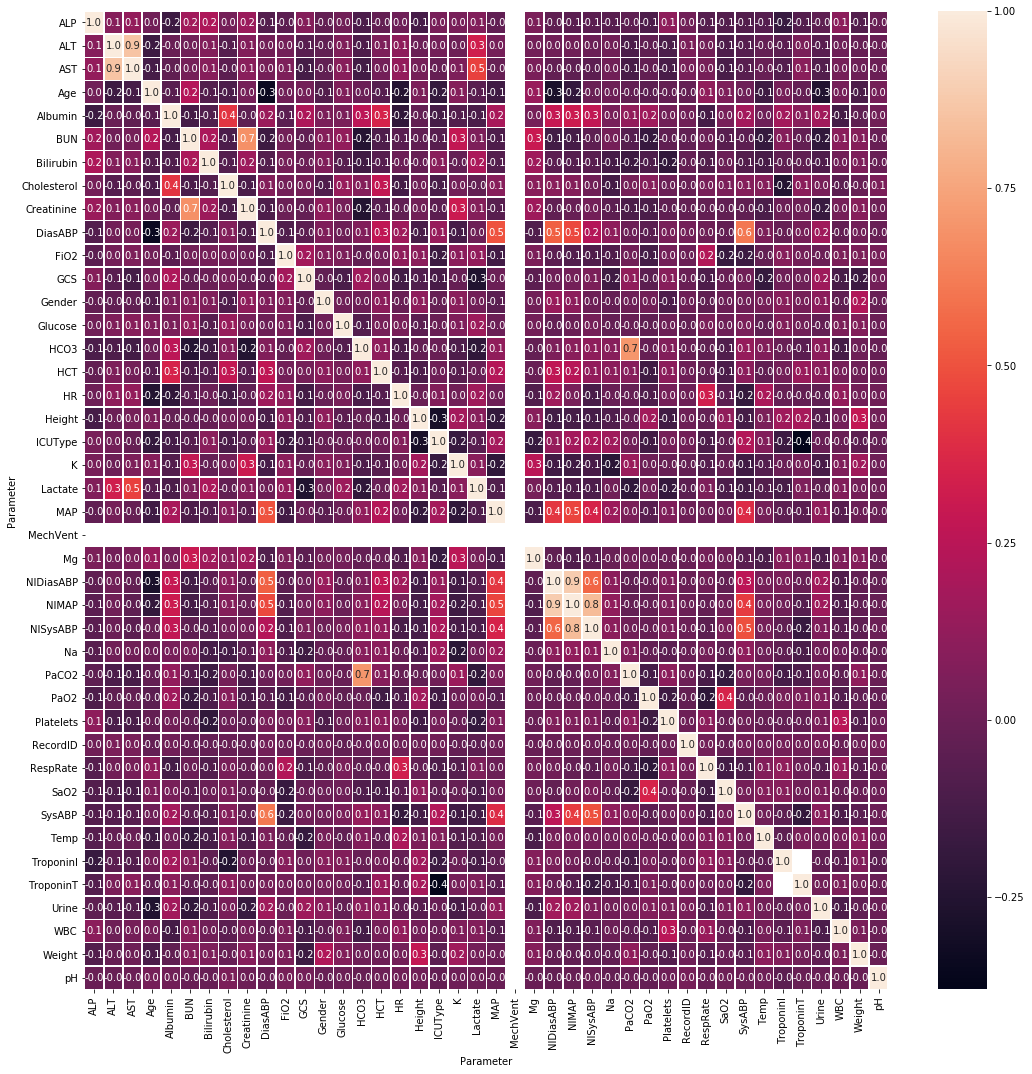

In [26]:
f,ax=plt.subplots(figsize=(18,18))
sns.heatmap(train.corr(),annot=True,linewidth=0.5,fmt='.1f')

Thus, we can take out some of the features in our training and testing set. We decided to take out those with a correlation score of >0.5. Those are: 
1. AST was taken out
2. NIDiasABP was taken out
3. NIMAP was taken out 
4. DiasABP was taken out
5. PaCO2 was taken out
6. BUN was taken out
6. **MechVent was taken out because its value does not change in the datasets**

We can also look to see if the static variable correlate, but they don't. Nonetheless, it's a good exercise.

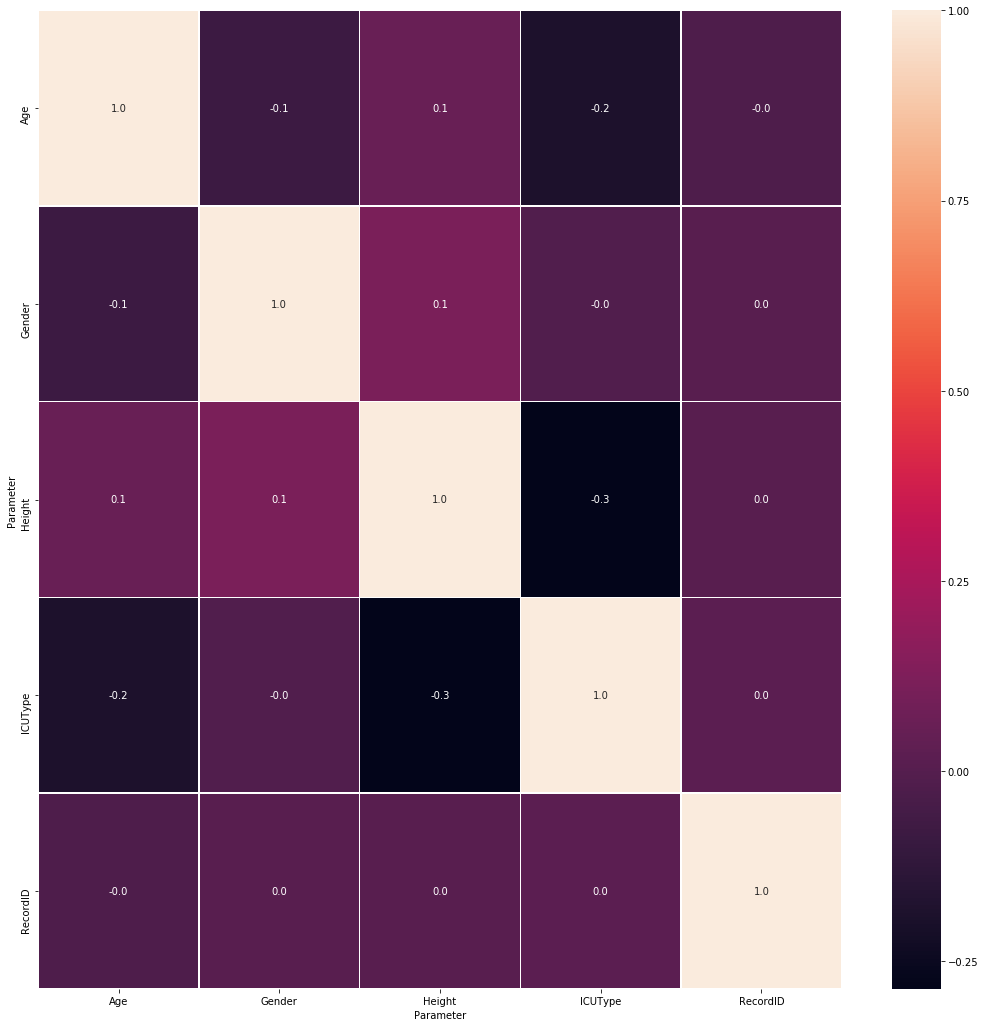

In [27]:
f,ax=plt.subplots(figsize=(18,18))
sns.heatmap(sTrain.corr(),annot=True,linewidth=0.5,fmt='.1f')

In [28]:
# Drop MechVent as well since the value does not change in the dataset and 
# this makes it hard to make correlative predictions among features
train_corr = train.drop(['AST','NIMAP', 'NIDiasABP', 'DiasABP', 'MechVent', 'PaCO2','BUN'], axis=1)
test_corr = test.drop(['AST','NIMAP', 'NIDiasABP', 'DiasABP', 'MechVent', 'PaCO2','BUN'], axis=1)

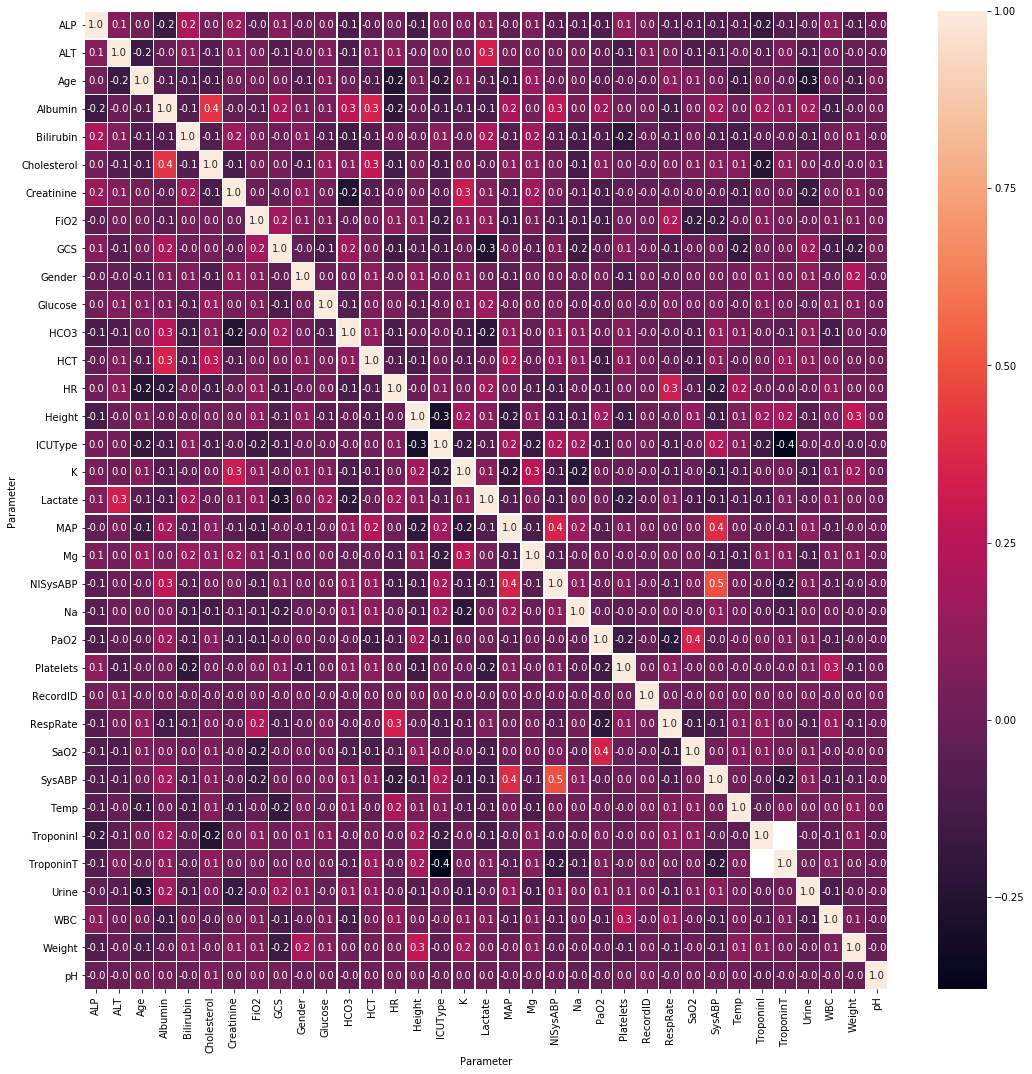

In [29]:
# Showing the heatmap again
f,ax=plt.subplots(figsize=(18,18))
sns.heatmap(train_corr.corr(),annot=True,linewidth=0.5,fmt='.1f')
plt.show()

### F. Binning in a time-course fashion (Emma MacDonald)

Despite the information we gleaned above, the way that the static and non-static feature dataframes currently look loses a lot of information. Therefore, we decided to bin like a time course, where each measurement is taken into consideration, in addition to some other marks like first, last, min, max and median of those measurements:

In [60]:
# First, let's list the features we want to keep in the data, modified with some features taken out
features = ['Albumin', 'ALP', 'ALT', 'Bilirubin', 'Cholesterol', 'Creatinine', 'FiO2', 'HCO3', 'HCT', 'K', 'Lactate', 'Mg', 'Na', 
            'PaO2', 'pH', 'Platelets', 'SysABP', 'TroponinI', 'TroponinT', 'WBC', 'Weight', 'GCS', 'Glucose', 'HR', 'MAP', 
            'NISysABP', 'RespRate', 'SaO2', 'Temp', 'Urine']

In [61]:
# Start from the beginning getting data from a list of lists
train = pd.DataFrame(txtfile_train, columns = ['Time', 'Parameter', 'Value', 'RecordID'])
test = pd.DataFrame(txtfile_test, columns = ['Time', 'Parameter', 'Value', 'RecordID'])

The following is just a reiteration of what was already done above before we looked at features that correlated. We added some dropping of -1 values with NaN values to hold place for the imputer coming up.

In [63]:
# Make a static data set from train (A) and test (B)
trainStaticData = train.loc[train['Time'] == '00:00', :].copy()
testStaticData = test.loc[test['Time'] == '00:00', :].copy()

staticVariables = ['RecordID','Age', 'Gender', 'Height', 'ICUType']
trainStaticData = trainStaticData.loc[train['Parameter'].isin(staticVariables)]
testStaticData = testStaticData.loc[test['Parameter'].isin(staticVariables)]

# Drop static variables from training and test sets
trainDrop = trainStaticData.index
train = train.loc[~train.index.isin(trainDrop),:]
testDrop = testStaticData.index
test = test.loc[~test.index.isin(testDrop),:]

# Make sure all values are numeric, group by RecordID in static table and pivot
test['Value'] = pd.to_numeric(test['Value'])
train['Value'] = pd.to_numeric(train['Value'])

trainStaticData = trainStaticData.groupby(['RecordID','Parameter'])[['Value']].last()
testStaticData = testStaticData.groupby(['RecordID','Parameter'])[['Value']].last()
trainStaticData.reset_index(inplace=True)
testStaticData.reset_index(inplace=True)

trainStaticData = trainStaticData.pivot(index='RecordID',columns='Parameter',values='Value')
testStaticData = testStaticData.pivot(index='RecordID',columns='Parameter',values='Value')

for column in testStaticData.columns:
    testStaticData[column] = pd.to_numeric(testStaticData[column])
    
for column in trainStaticData.columns:
    trainStaticData[column] = pd.to_numeric(trainStaticData[column])
    
# Replace -1 with NaN
testStaticData.Height.replace(-1, np.nan, inplace = True)
testStaticData.Age.replace(-1, np.nan, inplace = True)
testStaticData.Gender.replace(-1,np.nan, inplace = True)

trainStaticData.Height.replace(-1, np.nan, inplace = True)
trainStaticData.Age.replace(-1, np.nan, inplace = True)
trainStaticData.Gender.replace(-1,np.nan, inplace = True)

# Make copies of Static data and drop RecordID
Xa = trainStaticData.copy()
Xb = testStaticData.copy()

Xb.drop('RecordID', axis=1, inplace=True)
Xa.drop('RecordID', axis=1, inplace=True)

We want to add a min, max, first and last values to our train and test dataframes, then merge those the already existing frame

In [65]:
# Pull out the features we want to make temporary test and train sets only with those features
index = test['Parameter'].isin(features)
temporaryTest = test.loc[index,:].copy()
temporaryTest = temporaryTest.groupby(['RecordID','Parameter'])['Value']

index = train['Parameter'].isin(features)
temporaryTrain = train.loc[index,:].copy()
temporaryTrain = temporaryTrain.groupby(['RecordID','Parameter'])['Value']

In [66]:
# Make new slots of data with first, last, highest, lowest and median by using a df to add
# called X(a/b)_add and merge at the final step whilst pivoting
for point in ['first','last','highest','lowest','median']:
    if point == 'first':
        Xa_add = temporaryTrain.first()
        Xb_add = temporaryTest.first()
    elif point == 'last':
        Xa_add = temporaryTrain.last()
        Xb_add = temporaryTest.last()
    elif point == 'highest':
        Xa_add = temporaryTrain.max()
        Xb_add = temporaryTest.max()
    elif point == 'lowest':
        Xa_add = temporaryTrain.min()
        Xb_add = temporaryTest.min()
    elif point == 'median':
        Xa_add = temporaryTrain.median()
        Xb_add = temporaryTest.median()
    else:
        print('Skip')  
       
    Xa_add = Xa_add.reset_index()
    Xa_add = Xa_add.pivot(index='RecordID', columns='Parameter', values='Value')
    Xa_add.columns = [x + '-' + point for x in Xa_add.columns]
    Xa = Xa.merge(Xa_add, how='left', left_index = True, right_index=True)
    
    Xb_add = Xb_add.reset_index()
    Xb_add = Xb_add.pivot(index='RecordID', columns='Parameter', values='Value')
    Xb_add.columns = [x + '-' + point for x in Xb_add.columns]
    Xb = Xb.merge(Xb_add, how='left', left_index = True, right_index=True)

Now we bin by time, taking the last 2 integers of the minutes as a way of marking time:

In [68]:
index = train['Parameter'].isin(features)
raw_a = train.loc[index,:].copy()

index = test['Parameter'].isin(features)
raw_b = test.loc[index,:].copy()

# Bin time by extracting hour as integer
raw_a['Time_bin'] = [int(x[:2]) for x in raw_a.Time]
raw_b['Time_bin'] = [int(x[:2]) for x in raw_b.Time]

# bin time by hour and parameter measured
time_bins = raw_a.Time_bin.unique()
params = raw_a.Parameter.unique()

# Create groups of average value
grouped_a = raw_a.groupby(['RecordID','Parameter','Time_bin'])['Value'].mean()
grouped_b = raw_b.groupby(['RecordID','Parameter','Time_bin'])['Value'].mean()


# Fill Dataframe - check join for index match
for p in params: 
    for t in time_bins:
        name = p + '_' + str(t)
        
        vals_a = pd.DataFrame(grouped_a.loc[:,p,t]).rename(columns = {'Value':name})
        Xa = Xa.join(vals_a)
        
        vals_b = pd.DataFrame(grouped_b.loc[:,p,t]).rename(columns = {'Value':name})
        Xb = Xb.join(vals_b)

### G. Finding missing data and filling it in with FancyImpute (Kevin McPherson)

In [73]:
from fancyimpute import KNN # To fill in the missing data points we find
from sklearn.preprocessing import Imputer # As a backup, in case fancyimpute doesn't work. 

/Users/kevinmcpherson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now we want to go through the static and non-static datasets and see if there are any missing values. For the static variables, missing values are set as -1. Missing values in the other features are determined by the binning of time, so we'll use a fancy imputation method (literally) to do this. The imputation method is based on K-Nearest Neighbors algorithm, so we assume that most of the rows (i.e., patients in the ICU) have similar values

We already replaced all -1 with NaN, so now we need to find all those and replace them with actual numbers. But first, let's make sure Xa and Xb, now the names of our training and test sets respectively, don't have NaNs.

In [76]:
Xa.isnull()

,Age,Gender,Height,ICUType,ALP-first_x,ALT-first_x,Albumin-first_x,Bilirubin-first_x,Cholesterol-first_x,Creatinine-first_x,...,TroponinI_41,TroponinI_42,TroponinI_43,TroponinI_44,TroponinI_46,TroponinI_13,TroponinI_37,TroponinI_45,TroponinI_47,TroponinI_48
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,False,False,False,False,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
132540,False,False,False,False,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
132541,False,False,False,False,False,False,False,False,True,False,...,True,True,True,True,True,True,True,True,True,True
132543,False,False,False,False,False,False,False,False,True,False,...,True,True,True,True,True,True,True,True,True,True
132545,False,False,False,False,True,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,True
132547,False,False,False,False,False,False,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True
132548,False,False,False,False,True,True,True,True,True,False,...,True,True,True,True,True,False,True,True,True,True
132551,False,False,False,False,False,False,False,False,True,False,...,True,True,True,True,True,True,True,True,True,True
132554,False,False,False,False,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True


Yikes! Looks like there is a lot! 

That's ok, we'll use our imputer and remake our dataframe (KNN Imputer makes the df into an array, so we need to store the rows and columns before we use it! 

In [79]:
train_cols = list(Xa.columns)
train_rows = list(Xa.index)
test_cols = list(Xb.columns)
test_rows = list(Xb.index)

# THIS TAKES AN EXCEEDINGLY LONG TIME
knnImpute = KNN(k=3)
train_complete = knnImpute.fit_transform(Xa)
test_complete = knnImpute.fit_transform(Xb)

Imputing row 1/4000 with 1418 missing, elapsed time: 213.437
Imputing row 101/4000 with 1275 missing, elapsed time: 217.944
Imputing row 201/4000 with 1566 missing, elapsed time: 221.429
Imputing row 301/4000 with 1198 missing, elapsed time: 224.905
Imputing row 401/4000 with 1283 missing, elapsed time: 228.436
Imputing row 501/4000 with 1194 missing, elapsed time: 231.983
Imputing row 601/4000 with 1330 missing, elapsed time: 235.504
Imputing row 701/4000 with 1442 missing, elapsed time: 239.798
Imputing row 801/4000 with 1311 missing, elapsed time: 244.240
Imputing row 901/4000 with 1169 missing, elapsed time: 248.298
Imputing row 1001/4000 with 1275 missing, elapsed time: 252.056
Imputing row 1101/4000 with 1184 missing, elapsed time: 256.623
Imputing row 1201/4000 with 1270 missing, elapsed time: 261.349
Imputing row 1301/4000 with 1292 missing, elapsed time: 265.320
Imputing row 1401/4000 with 1259 missing, elapsed time: 269.941
Imputing row 1501/4000 with 1223 missing, elapsed ti

KeyboardInterrupt: 

OK, now we have complete training and testing sets, with no missing values

In [ ]:
train_complete = pd.DataFrame(train_complete)
train_complete.columns = train_cols
train_complete.index = train_rows

In [ ]:
test_complete = pd.DataFrame(test_complete)
test_complete.columns = test_cols
test_complete.index = test_rows

In [ ]:
train_complete.info()

In [ ]:
test_complete.info()

## F. Splitting training and testing sets from the training set itself (Emma MacDonald)

In [80]:
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix

/Users/kevinmcpherson/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


OK, so that FancyImputer took way too long. Let's just fill all the NaNs with 0s and call it a day (you can try the above if you want, but this is a way out. We also read in the outcomes here and make it clear that we are only interested in the "mortality" column of the outcome data. The outcome data is described by PhysioNet as:

> The outcome-related descriptors are kept in a separate CSV text file for each of the three record sets; as noted, only the file associated with training set A is available to participants. Each line of the outcomes file contains these descriptors:

- RecordID (defined as above)
- SAPS-I score (Le Gall et al., 1984)
- SOFA score (Ferreira et al., 2001)
- Length of stay (days)
- Survival (days)
- In-hospital death (0: survivor, or 1: died in-hospital)

In [81]:
# Remove columns with all Nan values AND fill Nan values with column mean
Xa = Xa.fillna(Xa.mean()).fillna(0)
Xb = Xb.fillna(Xb.mean()).fillna(0)

# Read the outcomes data into a df
ya = pd.read_csv('Outcomes-a.txt')
yb = pd.read_csv('Outcomes-b.txt')
    
ya.set_index('RecordID', inplace=True)
yb.set_index('RecordID', inplace=True)
ya.index.name = 'RecordID'
ya.index.name = 'RecordID'
# Xa = ya.merge(Xa, how='inner', left_index=True, right_index=True)
# Xb = yb.merge(Xb, how='inner', left_index=True, right_index=True)

# match X and y by RecordID
ya = ya.loc[Xa.index,'In-hospital_death']
yb = yb.loc[Xb.index,'In-hospital_death']
assert ((Xa.index == ya.index).sum() == Xa.shape[0])
assert ((Xb.index == yb.index).sum() == Xb.shape[0])

# Normalize
Xa_scale = StandardScaler().fit_transform(Xa)
Xb_scale = StandardScaler().fit_transform(Xb)

# Make training and test sets
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa_scale, ya, test_size=.3)

## Step 3: Clasification (Emma MacDonald)
In order to figure out which classifier algorithm is best for our data set, we tried a few with default hyperparameters. We visualized the TP, FP, TN and FN in a confusion matrix.

In [82]:
names = ["Nearest Neighbors", "Linear SVC", "Decision Tree",
         "Random Forest", "Naive Bayes","Logistic Regression"]
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression()]

def cm_display(cm):
  print('\tNegatives\tPositives')
  print('True\t'+ str(cm[0][0]) + '\t\t' + str(cm[0][1]))
  print('False\t' + str(cm[1][0]) + '\t\t' + str(cm[1][1]))
  
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for name, clf in zip(names, classifiers):
    try:
        clf.fit(Xa_train, ya_train)
        score = clf.score(Xa_test, ya_test)
        print('\n',name,'score:',score)
        cm_display(confusion_matrix(ya_test, clf.predict(Xa_test)))
        
    except:
        print(name,'did not work')


 Nearest Neighbors score: 0.8616666666666667
	Negatives	Positives
True	1030		1
False	165		4

 Linear SVC score: 0.7816666666666666
	Negatives	Positives
True	877		154
False	108		61

 Decision Tree score: 0.7966666666666666
	Negatives	Positives
True	908		123
False	121		48

 Random Forest score: 0.8608333333333333
	Negatives	Positives
True	1012		19
False	148		21

 Naive Bayes score: 0.2425
	Negatives	Positives
True	161		870
False	39		130

 Logistic Regression score: 0.7933333333333333
	Negatives	Positives
True	887		144
False	104		65


## Step 4: Hyperparameter Optimization using various methods (Emma MacDonald)

In [84]:
# Hyperparameter optimization with gridsearch
rf = RandomForestClassifier()
p_grid = {'n_estimators':[2,10,50,100,200], "max_depth":[1,3,5,7,9,None]}


grid_search = GridSearchCV(estimator=rf, param_grid=p_grid, cv=KFold(n_splits=5), iid=False)
grid_search.fit(Xa_scale, ya)
grid_search.best_params_

{'max_depth': None, 'n_estimators': 200}

In [85]:
# Train on entire set and pot performance on set b
rf = RandomForestClassifier(max_depth= None, n_estimators= 200)

rf.fit(Xa_scale,ya)
print( 'Score for set b:', rf.score(Xb_scale,yb))
cm_display(confusion_matrix(yb, rf.predict(Xb_scale)))

Score for set b: 0.87225
	Negatives	Positives
True	3401		31
False	480		88


Looking at the most important variables by time
Broke into quartiles variables binned by time:

- Early: 0 to 12 hours
- Early mid: 13 to 24 hours
- Late mid: 25 to 36 hours
- Late: 37 to 48 hours
- Determined highest driving features of patient death through fitting with RandomForestClassifier and taking feature importances **Cholesterol** seemed to be a important feature to predicting survival at **early, early-mid, and late-mid timepoints**.

Interestingly, the score changed ...

In [86]:
qrt1 = ['_0','_1','_2','_3','_4','_5','_6','7','_8','9','_10','_11','_12'] # Early
qrt2 = ['_13','_14','_15','_16','_17','_18','_19','_20','_21','_22','_23','_24'] # Early-mid
qrt3 = ['_25','_26','_27','_28','_29','_30','_31','_32','_33','_34','_35','_36'] # Late-mid
qrt4 = ['_37','_38','_39','_40','_41','_42','_43','_44','_45','_46','_47','_48'] # Late
quartiles = [('Early:', qrt1),('Early mid:',qrt2),('Late mid:',qrt3),('Late:', qrt4)]

for name,qrt in quartiles:
  print('\n'+name)
  X_train = Xa.loc[:,[c[-3:] in qrt for c in Xa.columns]]
  X_test = Xb.loc[:,[c[-3:] in qrt for c in Xa.columns]]
  y_train, y_test = ya, yb
# dtree = dtree = DecisionTreeClassifier(max_depth=1,max_features='sqrt')
  rf = RandomForestClassifier(max_depth= None, n_estimators= 100)
  rf.fit(X_train, y_train)
  print( 'Score for set b:', rf.score(X_test,y_test))
  cm_display(confusion_matrix(y_test, rf.predict(X_test)))
  impor = (rf.feature_importances_).argsort()
  print(X_train.columns[impor])


Early:
Score for set b: 0.85875
	Negatives	Positives
True	3423		9
False	556		12
Index(['Cholesterol_11', 'Cholesterol_12', 'ALT_11', 'Albumin_11',
       'Cholesterol_10', 'Bilirubin_11', 'SaO2_11', 'ALT_12', 'TroponinI_12',
       'TroponinT_12', 'ALT_10', 'ALP_10', 'ALP_11', 'Albumin_12',
       'Bilirubin_10', 'Albumin_10', 'SaO2_12', 'ALP_12', 'Bilirubin_12',
       'TroponinT_11', 'TroponinI_10', 'Creatinine_10', 'Mg_10', 'Mg_11',
       'Na_12', 'TroponinI_11', 'Mg_12', 'Creatinine_11', 'HCT_11', 'HCO3_10',
       'WBC_12', 'Na_11', 'Glucose_10', 'Glucose_12', 'Creatinine_12', 'K_10',
       'TroponinT_10', 'SaO2_10', 'HCO3_11', 'K_11', 'Na_10', 'HCO3_12',
       'K_12', 'Glucose_11', 'Platelets_11', 'HCT_10', 'Lactate_10', 'WBC_10',
       'Platelets_12', 'Lactate_11', 'HCT_12', 'WBC_11', 'PaO2_10',
       'Platelets_10', 'pH_11', 'Lactate_12', 'pH_10', 'RespRate_12',
       'PaO2_11', 'FiO2_10', 'PaO2_12', 'FiO2_11', 'FiO2_12', 'pH_12',
       'RespRate_10', 'RespRate_11', 'GC

## Step 5: Conclusions and Future Directions (Emma MacDonald and Kevin McPherson)
The Random Forest classifier was the best amongst several tests models to predict in-hospital deaths, however it had a high rate of false negatives.
The best time period of measurements for prediction seemed to be the first 12 hours.

Some of the future plans we have for this project include:
- Getting the imputer to work faster
- Visualization of the data over time, visualizing the hyperparameters in some way (maybe PCA)
- Overall speed optimizations for the general code 

## Workload Breakdown

This project was completed by Emma and Kevin exclusively. The work was split between Data Preprocessing/EDA (Kevin mostly) and Classification/HyperParameters/Scoring (Emma mostly) for a good 50/50 split. There was not help from Julio, unfortunately. 